# Deep Convolutional Generative Adversarial Network Example

Build a deep convolutional generative adversarial network (DCGAN) to generate digit images from a noise distribution with TensorFlow v2.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## DCGAN Overview

<img src="https://camo.githubusercontent.com/45e147fc9dfcf6a8e5df2c9b985078258b9974e3/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313030302f312a33394e6e6e695f6e685044614c7539416e544c6f57772e706e67" alt="dcgan" style="width: 1000px;"/>

References:
- [Unsupervised representation learning with deep convolutional generative adversarial networks](https://arxiv.org/pdf/1511.06434). A Radford, L Metz, S Chintala, 2016.
- [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html). X Glorot, Y Bengio. Aistats 9, 249-256
- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). Sergey Ioffe, Christian Szegedy. 2015.

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

In this example, each image will be converted to float32 and normalized from [0, 255] to [0, 1].

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [11]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

In [12]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
lr_generator = 0.0002
lr_discriminator = 0.0002
training_steps = 20000
batch_size = 128
display_step = 500

# Network parameters.
noise_dim = 100 # Noise data points.

In [13]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [14]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

In [15]:
# Create TF Model.
class Generator(Model):
    # Set layers.
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = layers.Dense(7 * 7 * 128)
        self.bn1 = layers.BatchNormalization()
        self.conv2tr1 = layers.Conv2DTranspose(64, 5, strides=2, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        self.conv2tr2 = layers.Conv2DTranspose(1, 5, strides=2, padding='SAME')

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        # Deconvolution, image shape: (batch, 14, 14, 64)
        x = self.conv2tr1(x)
        x = self.bn2(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        # Deconvolution, image shape: (batch, 28, 28, 1)
        x = self.conv2tr2(x)
        x = tf.nn.tanh(x)
        return x

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
class Discriminator(Model):
    # Set layers.
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv2D(64, 5, strides=2, padding='SAME')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(128, 5, strides=2, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024)
        self.bn3 = layers.BatchNormalization()
        self.fc2 = layers.Dense(2)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        return self.fc2(x)

# Build neural network model.
generator = Generator()
discriminator = Discriminator()

In [16]:
# Losses.
def generator_loss(reconstructed_image):
    gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=reconstructed_image, labels=tf.ones([batch_size], dtype=tf.int32)))
    return gen_loss

def discriminator_loss(disc_fake, disc_real):
    disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
    return disc_loss_real + disc_loss_fake

# Optimizers.
optimizer_gen = tf.optimizers.Adam(learning_rate=lr_generator)#, beta_1=0.5, beta_2=0.999)
optimizer_disc = tf.optimizers.Adam(learning_rate=lr_discriminator)#, beta_1=0.5, beta_2=0.999)

In [17]:
# Optimization process. Inputs: real image and noise.
def run_optimization(real_images):
    
    # Rescale to [-1, 1], the input range of the discriminator
    real_images = real_images * 2. - 1.

    # Generate noise.
    noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    
    with tf.GradientTape() as g:
            
        fake_images = generator(noise, is_training=True)
        disc_fake = discriminator(fake_images, is_training=True)
        disc_real = discriminator(real_images, is_training=True)

        disc_loss = discriminator_loss(disc_fake, disc_real)
            
    # Training Variables for each optimizer
    gradients_disc = g.gradient(disc_loss,  discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(gradients_disc,  discriminator.trainable_variables))
    
    # Generate noise.
    noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    
    with tf.GradientTape() as g:
            
        fake_images = generator(noise, is_training=True)
        disc_fake = discriminator(fake_images, is_training=True)

        gen_loss = generator_loss(disc_fake)
            
    gradients_gen = g.gradient(gen_loss, generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    
    return gen_loss, disc_loss

In [18]:
# Run training for the given number of steps.
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
    
    if step == 0:
        # Generate noise.
        noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
        gen_loss = generator_loss(discriminator(generator(noise)))
        disc_loss = discriminator_loss(discriminator(batch_x), discriminator(generator(noise)))
        print("initial: gen_loss: %f, disc_loss: %f" % (gen_loss, disc_loss))
        continue
    
    # Run the optimization.
    gen_loss, disc_loss = run_optimization(batch_x)
    
    if step % display_step == 0:
        print("step: %i, gen_loss: %f, disc_loss: %f" % (step, gen_loss, disc_loss))

initial: gen_loss: 0.694535, disc_loss: 1.403878
step: 500, gen_loss: 2.154825, disc_loss: 0.429040
step: 1000, gen_loss: 2.103464, disc_loss: 0.502638
step: 1500, gen_loss: 2.282369, disc_loss: 0.572065
step: 2000, gen_loss: 2.711531, disc_loss: 0.341791
step: 2500, gen_loss: 2.835576, disc_loss: 0.322356
step: 3000, gen_loss: 2.970127, disc_loss: 0.275483
step: 3500, gen_loss: 2.836321, disc_loss: 0.190680
step: 4000, gen_loss: 2.892855, disc_loss: 0.337681
step: 4500, gen_loss: 2.948962, disc_loss: 0.329322
step: 5000, gen_loss: 3.799061, disc_loss: 0.327288
step: 5500, gen_loss: 4.090328, disc_loss: 0.274685
step: 6000, gen_loss: 4.343777, disc_loss: 0.155223
step: 6500, gen_loss: 3.806556, disc_loss: 0.155855
step: 7000, gen_loss: 4.827947, disc_loss: 0.078372
step: 7500, gen_loss: 3.708949, disc_loss: 0.140979
step: 8000, gen_loss: 5.250406, disc_loss: 0.164736
step: 8500, gen_loss: 5.491106, disc_loss: 0.110080
step: 9000, gen_loss: 4.391072, disc_loss: 0.100240
step: 9500, gen_

In [19]:
# Visualize predictions.
import matplotlib.pyplot as plt

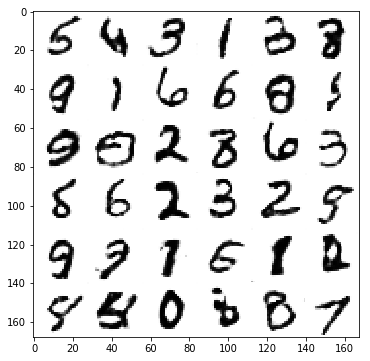

In [20]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.normal(-1., 1., size=[n, noise_dim]).astype(np.float32)
    # Generate image from noise.
    g = generator(z).numpy()
    # Rescale to original [0, 1]
    g = (g + 1.) / 2
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver código fuente en GitHub</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar el bloc de notas</a>
</td>
</table>

En este cuaderno se enseña la traducción de imagen a imagen no emparejadas con la red condicional de GAN, como se describe en [Traducción de imagen a imagen no emparejadas con las redes adversarias de ciclo constante](https://arxiv.org/abs/1703.10593), también conocido como CycleGAN. En el artículo se propone un método que puede capturar las características del dominio de una imagen y resolver cómo se podrían traducir estas características en el dominio de otra imagen, todo en ausencia de ejemplos de entrenamiento emparejados.

En este cuaderno se asume que usted tiene conocimientos de Pix2Pix, que puede aprenderlo en el [Tutorial de Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix). El código de CycleGAN es similar, la diferencia principal es la función de pérdida adicional y el uso de datos de entrenamiento no emparejados.

CycleGAN usa una pérdida de consistencia del ciclo para poder entrenarla sin datos emparejados. En otras palabras, puede traducir de un dominio a otro sin un mapeo de uno a uno entre el dominio de origen y el de destino.

Esto expande las posibilidades de hacer muchas tareas interesantes como mejorar fotografías, colorizar imágenes, transferir estilos, etc. Todo lo que necesita es un conjunto de datos de origen y uno de destino (que son simplemente directorios de imágenes).

![Output Image 1](images/horse2zebra_1.png) ![Output Image 2](images/horse2zebra_2.png)

## Preparación de la canalización de entrada

Instale el paquete [tensorflow_examples](https://github.com/tensorflow/examples) que permite importar el generador y el discriminador.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## Canalización de entrada

En este tutorial, se entrena un modelo para traducir desde imágenes de caballos a imágenes de cebras. Puede encontrar este conjunto de datos y otros similares [aquí](https://www.tensorflow.org/datasets/catalog/cycle_gan).

Como se menciona en el [artículo](https://arxiv.org/abs/1703.10593), aplique irregularidades y réplicas aleatorias en el conjunto de datos de entrenamiento. Estas son algunas de las técnicas de aumento de imagen que evitan el sobreajuste.

Es similar a lo que se hace en [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

- Al aplicar irregularidades de forma aleatoria, se cambia el tamaño de la imagen a `286 x 286` y se recorta aleatoriamente a `256 x 256`.
- Al aplicar reflejos de forma aleatoria, se voltea la imagen horizontalmente de forma aleatoria, es decir, de izquierda a derecha.

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## Importar y reusar los modelos Pix2Pix

Importe el generador y el discriminador que se usa en [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) a través del paquete instalado [tensorflow_examples](https://github.com/tensorflow/examples).

La arquitectura del modelo que se usa en este tutorial es muy similar a la que se usa en [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Estas son algunas de las diferencias:

- Cyclegan usa la [normalización de instancias](https://arxiv.org/abs/1607.08022) en vez de la [normalización de lotes](https://arxiv.org/abs/1502.03167).
- En el [artículo de CycleGAN](https://arxiv.org/abs/1703.10593) se usa un generador basado en `resnet`. En este tutorial se usa un generador `unet` por la simplicidad.

Se entrenarán 2 generadores (G y F) y 2 discriminadores (X e Y).

- El generador `G` aprende a transformar la imagen`X` en la imagen `Y`. $(G: X -> Y)$
- El generador `F` aprende a transformar la imagen `Y` en la imagen `X`. $(F: Y -> X)$
- El discriminador `D_X` aprende a diferenciar entre la imagen `X` y la imagen generada `X` (`F(Y)`).
- El discriminador `D_Y` aprende a diferenciar entre la imagen `Y` y la imagen generada `Y` (`G(X)`).

![Cyclegan model](images/cyclegan_model.png)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Funciones de pérdida

En CycleGAN, no hay datos emparejados con los que entrenar, por eso no hay garantía de que la pareja de la entrada `x` y de la salida `y` sea significativa durante el entrenamiento. Por eso. para reforzar que la red aprenda a mapear correctamente, los autores proponen la pérdida de consistencia del ciclo.

La pérdida del discriminador y la pérdida del generador son similares a las que se usan en [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

La consistencia del ciclo significa que los resultados deberían ser casi igual a la entrada original. Por ejemplo, si se traduce una oración del inglés al francés y luego se vuelve a traducir del francés al inglés, la oración resultante debería ser igual a la oración original.

En la pérdida de consistencia del ciclo,

- Se pasa la imagen $X$ por el generador $G$ que genera la imagen $\hat{Y}$.
- La imagen generada $\hat{Y}$ se pasa por el generador $F$ que nos da la imagen del ciclo $\hat{X}$.
- Se calcula el error absoluto de la media entre $X$ y $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$

![Cycle loss](images/cycle_loss.png)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

Como se mostró anteriormente, el generador $G$ tiene que traducir la imagen $X$ a la imagen $Y$. Según la pérdida de identidad, si se ingresa la imagen  $Y$ en el generador $G$, debería dar la imagen real $Y$ o algo que sea muy parecido a la $Y$.

Si ejecuta el modelo de cebra a caballo en un caballo o el modelo de caballo a cebra en una cebra, la imagen no se debería modificar tanto si la imagen ya contiene la clase de destino.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Inicialice los optimizadores para todos los generadores y discriminadores.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Puntos de verificación

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Entrenamiento

Nota: Este modelo de ejemplo es entrenado para menos épocas (10) que en el artículo (200) para que la duración de entrenamiento de este tutorial sea prudente. Las imágenes generadas tendrán mucha menos calidad.

In [ ]:
EPOCHS = 10

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

A pesar de que el bucle de entrenamiento parece complicado, consiste en cuatro pasos básicos:

- Obtener las predicciones.
- Calcular la pérdida.
- Calcular los gradientes con la retropropagación.
- Aplicar los gradientes en el optimizador.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generar con el conjunto de datos de prueba

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

## Próximos pasos

En este tutorial se muestra cómo implementar CycleGAN a partir del generador y el discriminador que se implementan en el tutorial de [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix). Su próximo paso a tomar puede ser usar diferentes conjuntos de datos de [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan).

También puede probar entrenarlo para más épocas para mejorar los resultados o puede implementar el generador ResNet modificado que se usa en el [artículo](https://arxiv.org/abs/1703.10593) en vez de usar el generador U-Net que se usa aquí.

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Redes generativas adversarias convolucionales profundas

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     Ver en TensorFlow.org</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/dcgan.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Ejecutar en Google Colab</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/dcgan.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     Ver código fuente en GitHub</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar el bloc de notas</a>
</td>
</table>

En este tutorial se enseña como generar imágenes de cifras escritas a mano con la [red generativa adversaria convolucional profunda](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN, por sus siglas en inglés). El código se escribe con la [API secuencial de Keras](https://www.tensorflow.org/guide/keras) con un bucle de entrenamiento `tf.GradientTape`.

## ¿Qué son las redes GAN?

Actualmente, las [redes generativas adversarias](https://arxiv.org/abs/1406.2661) (GAN, por sus siglas en inglés) son una de las ideas más interesantes en ciencias de la computación. Se entrenan dos modelos en simultáneo mediante un proceso adversario. Un *generador* ("el artista") aprende a crear imágenes que parecen reales, mientras que un *discriminador* ("el crítico de arte") aprende a diferenciar entre las imágenes reales y las falsas.

![A diagram of a generator and discriminator](./images/gan1.png)

Durante el entrenamiento, el *generador* es cada vez más bueno en crear imágenes que parecen reales, mientras que el *discriminador* es cada vez más bueno en notar la diferencia. El proceso encuentra un equilibrio cuando el *discriminador* ya no puede diferenciar entre las imágenes reales y las falsas.

![A second diagram of a generator and discriminator](./images/gan2.png)

En este cuaderno, se explica este proceso en un conjunto de datos MNIST. La siguiente animación muestra una serie de imágenes producidas por el *generador* durante un entrenamiento para 50 épocas. Al principio, las imágenes son ruido aleatorio y, con el tiempo, comienzan a lucir más como cifras escritas a mano.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

Para más información sobre las redes GAN, vea el curso de [introducción de aprendizaje profundo](http://introtodeeplearning.com/) de MIT.

### Preparación

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Cargar y preparar el conjunto de datos

Usará el conjunto de datos para entrenar el generador y el discriminador. El generador generará cifras escritas a mano que se parezcan a los datos de MNIST.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Crear los modelos

El generador y el discriminador se definen mediante el uso de la [API secuencial de Keras](https://www.tensorflow.org/guide/keras#sequential_model).

### El generador

El generador usa las capas `tf.keras.layers.Conv2DTranspose` (aumento de la resolución) para producir una imagen a partir de un valor de inicialización (ruido aleatorio). Comience con una capa `Dense` que tome este valor de inicialización como entrada, luego aumente la resolución varias veces hasta alcanzar el tamaño de imagen deseado de 28x28x1. Note la activación de `tf.keras.layers.LeakyReLU` para cada capa, excepto en la capa externa que usa tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use el generador (sin entrenamiento aún) para crear una imagen.

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### El discriminador

El discriminador es un clasificador de imágenes basadas en la red neuronal convolucional (CNN, por sus siglas en inglés).

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use el discriminador (sin entrenar aún) para clasificar las imágenes generadas en reales o falsas. El modelo será entrenado para que tenga como salida valores positivos para las imágenes reales y valores negativos para las imágenes falsas.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

## Definir la pérdida y los optimizadores

Defina las funciones de pérdida y los optimizadores para ambos modelos.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Pérdida del discriminador

Este método cuantifica qué tan bueno es el discriminador para distinguir entre imágenes reales y falsas. Compara las predicciones del discriminador sobre las imágenes reales en un arreglo de números 1 y las predicciones del discriminador sobre las imágenes falsas (generadas) en un arreglo de números 0.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Pérdida del generador

La pérdida del generador cuantifica qué tan bueno es para engañar al discriminador. De forma intuitiva, si el generador funciona bien, el discriminador clasificará a las imágenes reales en falsas (o con el número 1). Ahora, compare las decisiones del discriminador sobre las imágenes generadas en un arreglo de números 1.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Los optimizadores del discriminador y del generador son diferentes ya que se entrenarán dos redes por separado.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Guardar puntos de verificación

En este cuaderno también se enseñará cómo guardar y recuperar modelos, lo cual es útil en caso de que se interrumpa una tarea de ejecución larga.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Definir el bucle de entrenamiento


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

El bucle de entrenamiento comienza cuando el generador recibe un valor de inicialización aleatorio como entrada. Ese valor se usa para producir una imagen. Luego, se usa el discriminador para clasificar imágenes reales (extraídas del conjunto de datos de entrenamiento) e imágenes falsas (producidas por el generador). Se calcula la pérdida para cada uno de estos modelos y se usan los gradientes para actualizar el generador y el discriminador.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generar y guardar imágenes**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Entrenar el modelo

Llame al método `train()` que se definió anteriormente para entrenar el generador y el discriminador de forma simultánea. Nota: entrenar las redes GAN puede ser complicado. Es importante que el generador y el discriminador no se superpongan (por ejemplo, que sean entrenados al mismo ritmo).

Al principio del entrenamiento, las imágenes generadas lucirán como ruido aleatorio. A medida que el entrenamiento avanza, las cifras generadas se verán cada vez más reales. Luego de 50 épocas, se verán como las cifras del MNIST. Esto puede tardar un minuto/época con la configuración predeterminada en Colab.

In [ ]:
train(train_dataset, EPOCHS)

Restaurar el último punto de verificación

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Crear un GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` para crear un gif animado para usar imágenes que se guardaron durante el entrenamiento.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Próximos pasos


En este tutorial se mostró el código completo necesario para escribir y entrenar una red GAN. El siguiente paso que tome puede ser experimentar con diferentes conjuntos de datos, por ejemplo, el conjunto de datos de atributos de las caras de celebridades a gran escala (CelebA) [disponible en Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). Para más información sobre las redes GAN, vea el [Tutorial de NIPS 2016: Redes generativas adversarias](https://arxiv.org/abs/1701.00160).


##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix: Traducción de imagen a imagen con un GAN condicional

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver fuente en GitHub</a>
</td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar el bloc de notas</a></td>
</table>

En este tutorial se muestra cómo construir y entrenar una red generativa condicional adversarial (cGAN) llamada pix2pix, la cual aprende un mapeo desde las imágenes de entrada a las de salida, como se describe en [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004){:.external} de Isola et al. (2017). pix2pix no es específico de una determinada aplicación, sino que puede aplicarse a una amplia gama de tareas, como sintetizar fotos a partir de mapas de etiquetas, generar fotos coloreadas a partir de imágenes en blanco y negro, convertir fotos de Google Maps en imágenes aéreas e incluso transformar bocetos en fotos.

En este ejemplo, su red generará imágenes de fachadas de edificios utilizando la base de datos [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) proporcionada por el [Center for Machine Perception](http://cmp.felk.cvut.cz/){:.external} de la [Universidad Técnica Checa de Praga](https://www.cvut.cz/){:.external}. Para abreviar, utilizará una copia [preprocesada](https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external} de este conjunto de datos creado por los autores de pix2pix.

En el cGAN pix2pix, se condiciona a las imágenes de entrada y se generan las imágenes de salida correspondientes. Los cGAN se propusieron por primera vez en [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza y Osindero, 2014)

La arquitectura de tu red incluirá:

- Un generador con una arquitectura basada en [U-Net](https://arxiv.org/abs/1505.04597){:.external}.
- Un discriminador representado por un clasificador PatchGAN convolucional (propuesto en el documento [pix2pix](https://arxiv.org/abs/1611.07004){:. external}).

Tenga en cuenta que cada época puede tardar unos 15 segundos en una sola GPU V100.

A continuación se muestran algunos ejemplos de la salida generada por el cGAN pix2pix después de entrenar durante 200 épocas en el conjunto de datos de fachadas (80,000 pasos).

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png) ![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Importar TensorFlow y otras bibliotecas

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## Cargar el conjunto de datos

Descargue los datos de la base de datos de fachadas CMP (30MB). Los conjuntos de datos adicionales están disponibles en el mismo formato [aquí](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external}. En Colab puede seleccionar otros conjuntos de datos en el menú desplegable. Tenga en cuenta que algunos de los otros conjuntos de datos son significativamente mayores (`edges2handbags` tiene un tamaño de 8 GB). 

In [ ]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [ ]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

In [ ]:
list(PATH.parent.iterdir())

Cada imagen original es de tamaño `256 x 512` y contiene dos imágenes `256 x 256`:

In [ ]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

In [ ]:
plt.figure()
plt.imshow(sample_image)

Es necesario separar las imágenes reales de las fachadas de los edificios de las imágenes de las etiquetas de arquitectura, todas ellas de tamaño `256 x 256`.

Defina una función que cargue archivos de imagen y dé como salida dos tensores de imágenes:

In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Represente una muestra de las imágenes de entrada (imagen de la etiqueta de arquitectura) y reales (foto de la fachada del edificio):

In [ ]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

Tal y como se describe en el documento [pix2pix](https://arxiv.org/abs/1611.07004){:.external}, es necesario aplicar el jittering aleatorio y el reflejo para preprocesar el conjunto de entrenamiento.

Defina varias funciones que:

1. Cambie el tamaño de cada imagen `256 x 256` a un alto y ancho mayores-`286 x 286`.
2. Recórtelo aleatoriamente a `256 x 256`.
3. Dé la vuelta a la imagen horizontalmente de forma aleatoria, es decir, de izquierda a derecha (reflejo aleatorio).
4. Normalice las imágenes al rango `[-1, 1]`.

In [ ]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

Puede inspeccionar parte de la salida preprocesada:

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

Después de comprobar que la carga y el preprocesamiento funcionan, definamos un par de funciones de ayudante que carguen y preprocesen los conjuntos de entrenamiento y de prueba:

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Cree una canalización de entrada con `tf.data`

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Construya el generador

El generador de su cGAN pix2pix es un [U-Net](https://arxiv.org/abs/1505.04597)*modificado* {:.external}. Una U-Net consta de un codificador (downsampler) y un decodificador (upsampler). (Puede encontrar más información al respecto en el tutorial [Segmentación de imágenes](../images/segmentation.ipynb) y en la página web del proyecto [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}).

- Cada bloque del codificador es Convolution -&gt; Batch normalization -&gt; Leaky ReLU
- Cada bloque del descodificador es Transposed convolution -&gt; Batch normalization -&gt; Dropout (aplicado a los 3 primeros bloques) -&gt; ReLU
- Hay conexiones de omisión entre el codificador y el decodificador (como en la U-Net).

Defina el reductor de muestreo o downsampler (codificador):

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

Defina el amplificador de muestreo o upsampler (decodificador):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

Defina el generador con el "downsampler" y el "upsampler":

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualice la arquitectura del modelo generador:

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Pruebe el generador:

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Defina la pérdida del generador

Las GAN aprenden que una pérdida se adapta a los datos, mientras que las cGAN aprenden una pérdida estructurada que penaliza una posible estructura que difiera de la salida de la red y de la imagen objetivo, como se describe en el documento [pix2pix](https://arxiv.org/abs/1611.07004){:.external}.

- La pérdida del generador es una pérdida de entropía cruzada sigmoidea de las imágenes generadas y un **arreglo de unos**.
- El documento pix2pix también menciona la pérdida L1, que es un MAE (error promedio absoluto) entre la imagen generada y la imagen objetivo.
- Esto permite que la imagen generada se asemeje estructuralmente a la imagen objetivo.
- La fórmula para calcular la pérdida total del generador es `gan_loss + LAMBDA * l1_loss`, donde `LAMBDA = 100`. Este valor se decidió por los autores del documento.

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

El procedimiento de entrenamiento del generador es el siguiente:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Construya el discriminador

El discriminador en el cGAN pix2pix es un clasificador PatchGAN convolucional: intente clasificar si cada imagen *patch* es real o no es real, como se describe en el documento [pix2pix](https://arxiv.org/abs/1611.07004){:.external}.

- Cada bloque del discriminador es Convolution -&gt; Batch normalization -&gt; Leaky ReLU.
- La forma de la salida después de la última capa es `(batch_size, 30, 30, 1)`.
- Cada parche de imagen `30 x 30` de la salida clasifica una porción `70 x 70` de la imagen de entrada.
- El discriminador recibe 2 entradas:
    - La imagen de entrada y la imagen objetivo, que deben clasificarse como reales.
    - La imagen de entrada y la imagen generada (la salida del generador), que debe clasificarse como falsa.
    - Utilice `tf.concat([inp, tar], axis=-1)` para concatenar estas 2 entradas.

Vamos a definir el discriminador:

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualice la arquitectura del modelo discriminador:

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Pruebe el discriminador:

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Defina la pérdida del discriminador

- La función `discriminator_loss` toma 2 entradas: **imágenes reales** e **imágenes generadas**.
- `real_loss` es una pérdida de entropía cruzada sigmoidea de las **imágenes reales** y un **arreglo de unos (ya que éstas son las imágenes reales)**.
- `generated_loss` es una pérdida de entropía cruzada sigmoide de las **imágenes generadas** y un **arreglo de ceros (ya que éstas son las imágenes falsas)**.
- La `total_loss` es la suma de `real_loss` y `generated_loss`.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

A continuación se muestra el procedimiento de entrenamiento del discriminador.

Para obtener más información sobre la arquitectura y los hiperparámetros, puede consultar el documento [pix2pix](https://arxiv.org/abs/1611.07004){:.external}.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Defina los optimizadores y un salvador de puntos de verificación


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generar imágenes

Escriba una función para trazar algunas imágenes durante el entrenamiento.

- Pasar imágenes del equipo de pruebas al generador.
- A continuación, el generador traducirá la imagen de entrada a la de salida.
- ¡El último paso consiste en representar gráficamente las predicciones y *voila*!

Nota: El `training=True` es intencional aquí ya que usted quiere las estadísticas por lotes, mientras ejecuta el modelo en el conjunto de datos de prueba. Si utiliza `training=False`, obtendrá las estadísticas acumuladas aprendidas del conjunto de datos de entrenamiento (que no desea).

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Pruebe la función:

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Entrenamiento

- Para cada entrada de ejemplo se genera una salida.
- El discriminador recibe como primera entrada la `input_image` y la imagen generada. La segunda entrada es la `input_image` y la `target_image`.
- A continuación, calcule la pérdida del generador y del discriminador.
- A continuación, calcule los gradientes de pérdida con respecto a las variables generadoras y discriminadoras (entradas) y aplíquelos al optimizador.
- Por último, registre las pérdidas en TensorBoard.

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

El bucle de entrenamiento propiamente dicho. Como este tutorial puede ejecutarse con más de un conjunto de datos, y éstos varían mucho en tamaño, el bucle de entrenamiento está configurado para trabajar por pasos en vez de por épocas.

- Itera sobre el número de pasos.
- Cada 10 pasos imprime un punto (`.`).
- Cada 1,000 pasos: borre la pantalla y ejecute `generate_images` para mostrar el progreso.
- Cada 5,000 pasos: guarde un punto de verificación.

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Este bucle de entrenamiento guarda registros que puede ver en TensorBoard para supervisar el progreso del entrenamiento.

Si trabaja en una máquina local, lanzaría un proceso TensorBoard separado. Cuando trabaje en un cuaderno, lance el visor antes de iniciar el entrenamiento para monitorizar con TensorBoard.

Inicie el visor TensorBoard (Lo sentimos, esto no se muestra en tensorflow.org):

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Puede ver los [resultados de una ejecución previa](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) de este bloc de notas en [TensorBoard.dev](https://tensorboard.dev/).

Por último, ejecute el bucle de entrenamiento:

In [ ]:
fit(train_dataset, test_dataset, steps=40000)

La interpretación de los registros es más sutil cuando se entrena un GAN (o un cGAN como pix2pix) en comparación con un modelo sencillo de clasificación o regresión. Cosas en las que debe fijarse:

- Revise que ni el modelo generador ni el discriminador hayan "ganado". Si el `gen_gan_loss` o el `disc_loss` se vuelven muy bajos, es un indicador de que este modelo está dominando al otro, y usted no está entrenando correctamente el modelo combinado.
- El valor `log(2) = 0.69` es un buen punto de referencia para estas pérdidas, ya que indica una perplejidad de 2: el discriminador tiene, por término medio, la misma incertidumbre sobre las dos opciones.
- Para el `disc_loss`, un valor inferior a `0,69` significa que el discriminador obtiene mejores resultados que el azar en el conjunto combinado de imágenes reales y generadas.
- Para el `gen_gan_loss`, un valor inferior a `0,69` significa que el generador lo hace mejor que el azar al momento de engañar al discriminador.
- A medida que progresa el entrenamiento, la `gen_l1_loss` debería disminuir.

## Restaure el último punto de verificación y pruebe la red

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Genere algunas imágenes utilizando el conjunto de prueba

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)